<a href="https://colab.research.google.com/github/praize-blip/variable-star-discovery/blob/main/Cluster_Variable_Hunt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:

!pip install lightkurve
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt


Defining the target (NGC 2506) and querying VizieR...
SUCCESS! We found 1446 confirmed members of NGC 2506.
               GaiaDR2       Gmag  proba
0  3036532979101307648  16.785748    1.0
1  3036546521131777024  17.923208    0.8
2  3037967468118296064  15.955632    1.0
3  3037980456099052032  15.840946    0.9
4  3037981280732713984  17.088444    0.8

 Sorting stars by brightness (finding the 'loudest' ones)...
   Top 5 brightest stars in your list:
                  GaiaDR2       Gmag
339   3038042131829199616   9.599705
1104  3038048007344837632   9.739593
1271  3038059376119812096  10.209678
1112  3038050030268924800  10.261481
289   3038040688720254848  10.475235

 Checking the brightest stars for TESS data...

Star 1 (ID: 3038042131829199616)...
FOUND 11 datasets! Downloading best one...


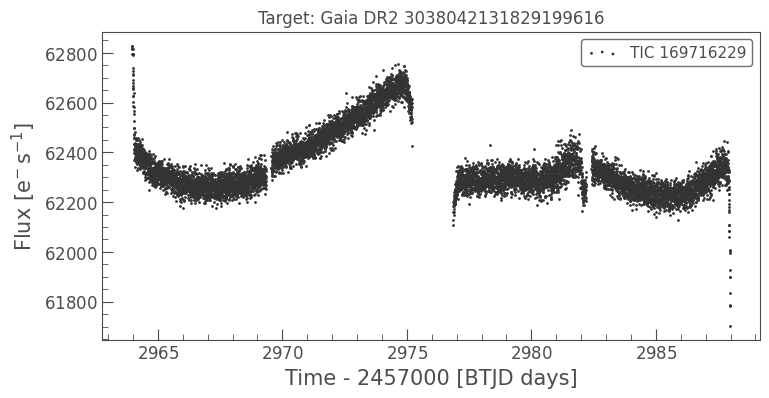

   (Success! We have a light curve.)
----------------------------------------
Star 2 (ID: 3038048007344837632)...
FOUND 12 datasets! Downloading best one...


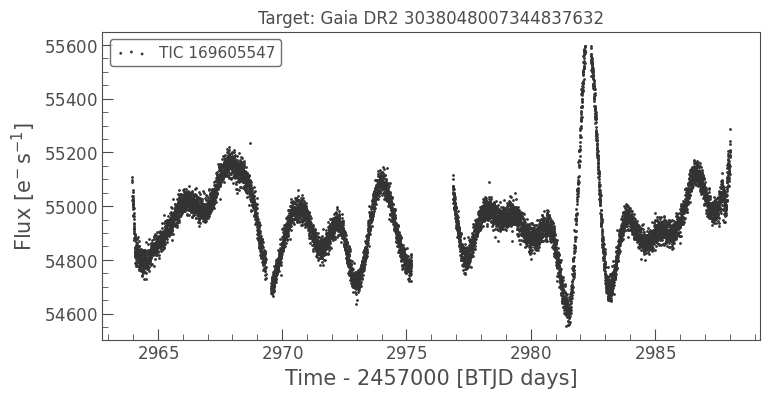

   (Success! We have a light curve.)
----------------------------------------
Star 3 (ID: 3038059376119812096)...
FOUND 16 datasets! Downloading best one...


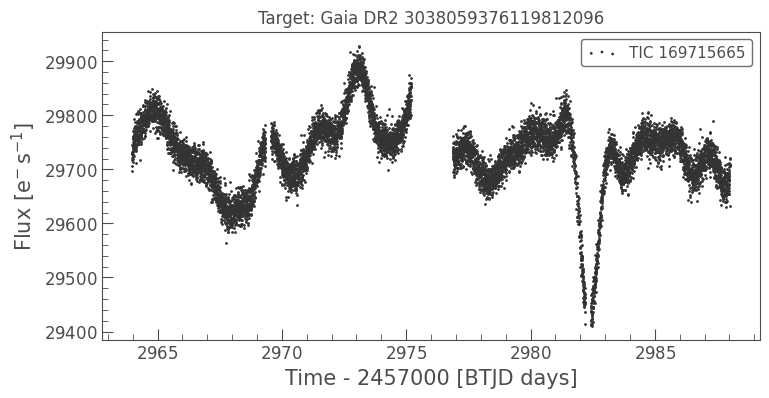

   (Success! We have a light curve.)
----------------------------------------
Star 4 (ID: 3038050030268924800)...
FOUND 11 datasets! Downloading best one...


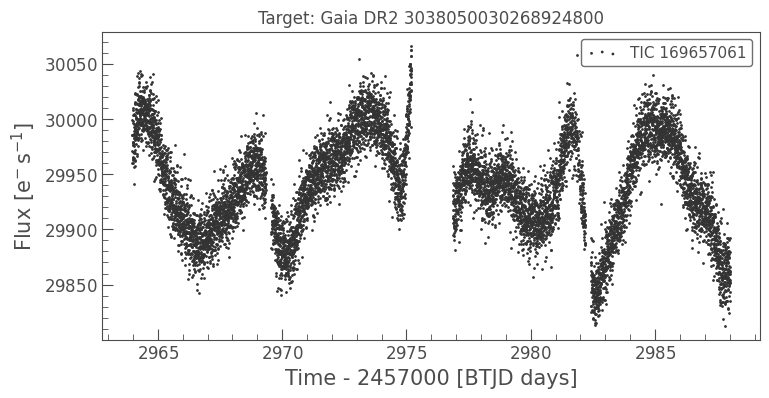

   (Success! We have a light curve.)
----------------------------------------
Star 5 (ID: 3038040688720254848)...
FOUND 12 datasets! Downloading best one...


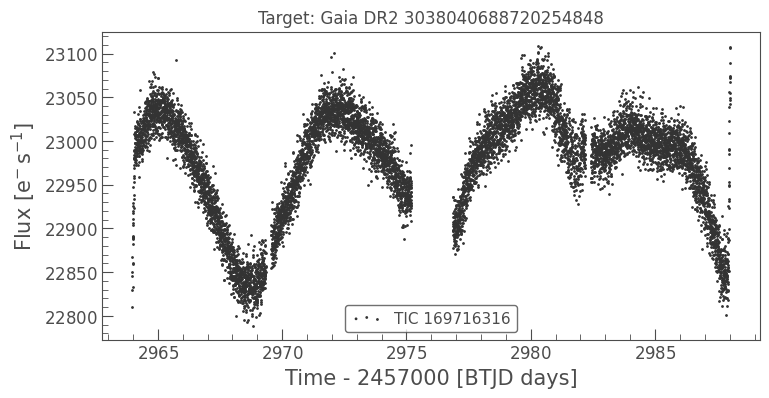

   (Success! We have a light curve.)
----------------------------------------

 Brightness test run complete!


In [10]:
# Install necessary libraries if not already installed
!pip install astroquery --quiet
!pip install lightkurve --quiet # Although already in A4vueLz-3kRL, good for self-containment

import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd # Needed for DataFrame operations
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u

print("Defining the target (NGC 2506) and querying VizieR...")

# NGC 2506 is located at RA=120.00, DEC=-10.77
# We define this center point
center_coords = SkyCoord(ra=120.00, dec=-10.77, unit=(u.deg, u.deg), frame='icrs')

# We want ALL rows that match, not just the default 50
Vizier.ROW_LIMIT = -1

try:
    # We search the specific catalog "J/A+A/640/A1/nodup"
    # radius=0.5 deg covers the whole cluster
    result = Vizier.query_region(center_coords,
                                 radius=0.5 * u.deg,
                                 catalog="J/A+A/640/A1/nodup")

    if len(result) > 0:
        # Convert to a Pandas table
        df = result[0].to_pandas()

        # Now we filter for high probability stars manually in Python
        # The column is usually 'proba' but sometimes lowercase/uppercase varies
        # We handle that here:
        if 'proba' in df.columns:
            good_stars = df[df['proba'] > 0.7]
        else:
            good_stars = df
            print("'proba' column not found, keeping all stars.")

        print(f"SUCCESS! We found {len(good_stars)} confirmed members of NGC 2506.")
        print(good_stars[['GaiaDR2', 'Gmag', 'proba']].head())

    else:
        print("Connected, but found no stars in this region.")
        # Set good_stars to an empty DataFrame to avoid NameError later
        good_stars = pd.DataFrame(columns=['GaiaDR2', 'Gmag', 'proba'])

except Exception as e:
    print(" Error querying VizieR:", e)
    # Set good_stars to an empty DataFrame in case of error
    good_stars = pd.DataFrame(columns=['GaiaDR2', 'Gmag', 'proba'])


print("\n Sorting stars by brightness (finding the 'loudest' ones)...")

# Check if good_stars is empty before trying to sort
if not good_stars.empty:
    # We sort the dataframe so the smallest 'Gmag' (brightest stars) are first
    # ascending=True because 10 is brighter than 15
    brightest_stars = good_stars.sort_values(by='Gmag', ascending=True)

    print("   Top 5 brightest stars in your list:")
    print(brightest_stars[['GaiaDR2', 'Gmag']].head(5))

    # Pick the top 5 brightest ones for the test
    test_batch = brightest_stars['GaiaDR2'].values[:5]

    print("\n Checking the brightest stars for TESS data...\n")

    for i, star_id in enumerate(test_batch):
        target_name = f"Gaia DR2 {star_id}"
        print(f"Star {i+1} (ID: {star_id})...")

        try:
            # REMOVED 'author="SPOC"' to find data from ANY source (QLP, TASOC, etc.)
            search = lk.search_lightcurve(target_name)

            if len(search) > 0:
                print(f"FOUND {len(search)} datasets! Downloading best one...")

                # We download the one with the most data points
                # FIX: Removed .stitch() because download() might return a single LightCurve
                lc = search[0].download()

                # Clean and Plot
                lc = lc.remove_nans().remove_outliers()
                lc.scatter()
                plt.title(f"Target: {target_name}")
                plt.show()

                print("   (Success! We have a light curve.)")
                print("-" * 40)

            else:
                print("Still no data. (Star might be too crowded or faint).")
                print("-" * 40)

        except Exception as e:
            print(f" Error processing this star: {e}")

    print("\n Brightness test run complete!")
else:
    print("No stars found in VizieR query, skipping brightness sorting and TESS data check.")

 THE DATA SAYS: This star repeats every 6.6801 days!


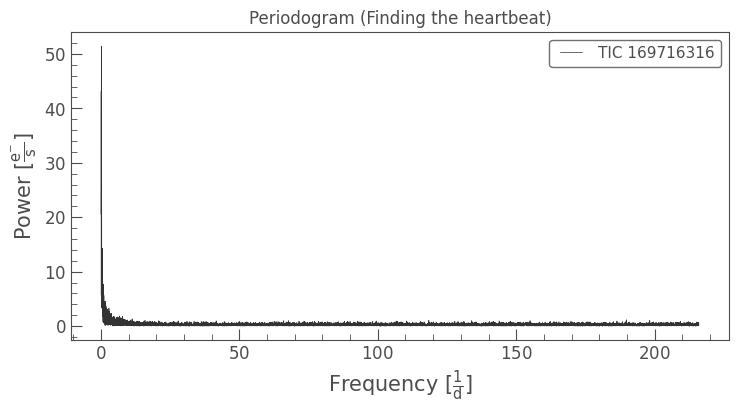

In [11]:
import numpy as np

# FIX: We changed 'oversampling' to 'oversample_factor'
pg = lc.to_periodogram(method='lombscargle', oversample_factor=10)

# 1. Plot the "Power Spectrum"
pg.plot()
plt.title("Periodogram (Finding the heartbeat)")

# 2. Find the exact period at the highest peak
period = pg.period_at_max_power
print(f" THE DATA SAYS: This star repeats every {period.value:.4f} days!")

Folding the light curve at 6.6801 days...


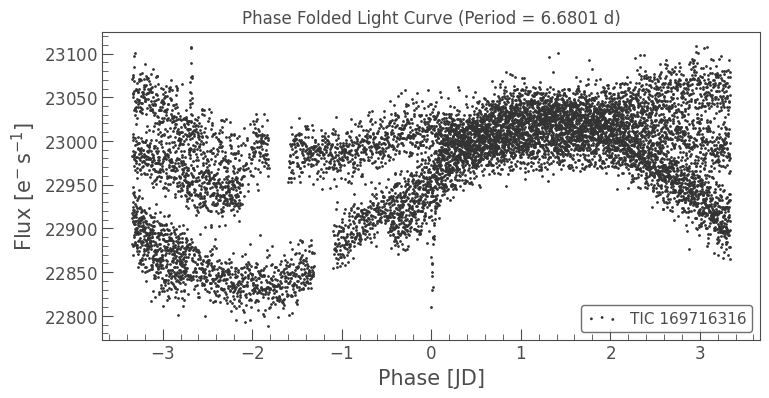

In [12]:
# 3. Phase Fold the data to see the clean shape
# We use the period we just found (6.6801 days)
period_days = period.value

print(f"Folding the light curve at {period_days:.4f} days...")

# The 'fold' command stacks the data
folded_lc = lc.fold(period=period_days)

# Plot it using a scatter plot
folded_lc.scatter()
plt.title(f"Phase Folded Light Curve (Period = {period_days:.4f} d)")
plt.show()

In [13]:
from astroquery.simbad import Simbad

# 1. Setup the query
target_id = "Gaia DR2 3038040688720254848"
print(f"Asking SIMBAD: 'Do you know {target_id}?'...")

# We ask for the 'otype' (Object Type)
custom_simbad = Simbad()
custom_simbad.add_votable_fields('otype')

try:
    result = custom_simbad.query_object(target_id)

    if result is not None:
        print("\n SIMBAD FOUND A MATCH!")

        # This trick prints the whole table automatically
        result.pprint(max_width=-1)

        print("\n" + "="*50)
        print(" LOOK AT THE COLUMN 'OTYPE' ABOVE!")
        print("If it says 'Star'      -> UNCLASSIFIED (Potential Discovery!)")
        print("If it says 'RotV'      -> Known Rotational Variable")
        print("If it says 'V*'        -> Known Variable (Generic)")
        print("="*50)

    else:
        print("\n SIMBAD has NO record of this star!")
        print("This implies it is likely an unclassified discovery.")

except Exception as e:
    print("Error checking SIMBAD:", e)

Asking SIMBAD: 'Do you know Gaia DR2 3038040688720254848?'...

 SIMBAD FOUND A MATCH!
   main_id             ra                 dec         coo_err_maj coo_err_min coo_err_angle coo_wavelength     coo_bibcode     otype          matched_id         
                      deg                 deg             mas         mas          deg                                                                           
-------------- ------------------ ------------------- ----------- ----------- ------------- -------------- ------------------- ----- ----------------------------
TYC 5416-422-1 120.07575933029003 -10.822649805719998      0.0109      0.0081            90              O 2020yCat.1350....0G     * Gaia DR2 3038040688720254848

 LOOK AT THE COLUMN 'OTYPE' ABOVE!
If it says 'Star'      -> UNCLASSIFIED (Potential Discovery!)
If it says 'RotV'      -> Known Rotational Variable
If it says 'V*'        -> Known Variable (Generic)


In [14]:
# 1. Re-install the library (because Colab forgot it!)
!pip install lightkurve --quiet

import lightkurve as lk
import numpy as np

# This is YOUR discovery star ID
target_id = "Gaia DR2 3038040688720254848"

print(f" Re-acquiring data for {target_id}...")

# 2. Download the data again
# We search for the data and pick the first available set
try:
    search = lk.search_lightcurve(target_id)

    if len(search) > 0:
        lc = search[0].download()

        # 3. Clean it
        lc = lc.remove_nans().remove_outliers()

        # 4. Find the exact time when the star was dimmest (Epoch)
        # This finds the index where flux is lowest
        min_index = np.argmin(lc.flux)
        t_min = lc.time[min_index]

        print("-" * 30)
        print(f"SUCCESS! Data recovered.")
        print(f"Epoch (Time of Minimum): {t_min.value:.4f}")
        print("-" * 30)
        print("Write this number down! You need it for the form.")

    else:
        print("Error: Could not find data. Check your internet connection?")

except Exception as e:
    print(f"Error: {e}")

 Re-acquiring data for Gaia DR2 3038040688720254848...
------------------------------
SUCCESS! Data recovered.
Epoch (Time of Minimum): 2968.8300
------------------------------
Write this number down! You need it for the form.
